In [1]:
!rm -rf /kaggle/working/*

In [2]:
import os
import pickle
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load labels from pickle file
with open('/kaggle/input/brain-tumor-dataset/Dataset/labels.pickle', 'rb') as f:
    labels = pickle.load(f)

# Define image and mask directories
image_dir = '/kaggle/input/brain-tumor-dataset/Dataset/Images'
mask_dir = '/kaggle/input/brain-tumor-dataset/Dataset/Masks'

# Create list of image and mask paths
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]
mask_paths = [os.path.join(mask_dir, filename) for filename in os.listdir(mask_dir)]

class MedicalImageDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None, target_size=(128, 128), pad_size=(192, 192)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform
        self.target_size = target_size
        self.pad_size = pad_size

    def __len__(self):
        return len(self.image_paths)

    def preprocess(self, image_path, mask_path):
        image = Image.open(image_path).convert('L')
        image = image.resize(self.target_size)
        
        mask = Image.open(mask_path).convert('L')
        mask = mask.resize(self.target_size)

        image = transforms.ToTensor()(image).float()
        mask = transforms.ToTensor()(mask).float()
        mask = (mask > 0).float()

        return image, mask

    def pad_image(self, image):
        pad_h = (self.pad_size[0] - image.size(1)) // 2
        pad_w = (self.pad_size[1] - image.size(2)) // 2

        image = F.pad(image, (pad_w, pad_w, pad_h, pad_h), 'constant', 0)

        return image

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        label = self.labels[idx]

        image, mask = self.preprocess(image_path, mask_path)
        image= self.pad_image(image)
#         print("image size", image.shape)
#         print("mask size", mask.shape)

        return image, mask, label

# Split the dataset into training and testing sets
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths, train_labels, test_labels = train_test_split(
    image_paths, mask_paths, labels, test_size=0.2, random_state=42)

# Define the dataset
train_dataset = MedicalImageDataset(train_image_paths, train_mask_paths, train_labels)
test_dataset = MedicalImageDataset(test_image_paths, test_mask_paths, test_labels)

# Define DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [3]:
cnt_b=0
for image,mask,label in train_loader:
    cnt_b+=1
    
print(cnt_b)

77


In [4]:
image, mask, label=next(iter(train_loader))

In [5]:
print(image.shape," img_shape")
print(mask.shape," mask_shape")
print(label," label")

torch.Size([32, 1, 192, 192])  img_shape
torch.Size([32, 1, 128, 128])  mask_shape
tensor([3., 3., 2., 3., 2., 3., 1., 3., 2., 3., 1., 3., 2., 2., 2., 2., 1., 2.,
        3., 3., 2., 1., 1., 2., 2., 3., 2., 3., 3., 3., 1., 3.],
       dtype=torch.float64)  label


In [6]:
import matplotlib.pyplot as plt

torch.Size([192, 192])


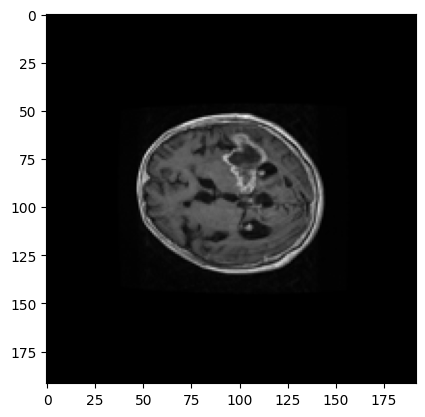

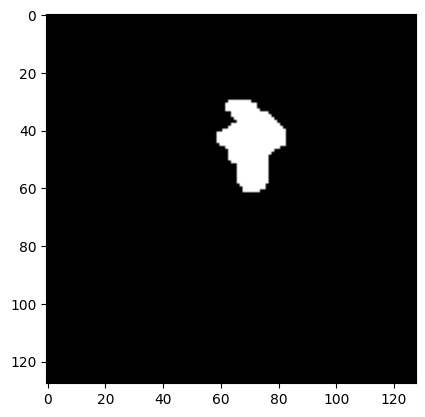

In [7]:
plt.imshow(image[0][0],cmap='gray')
print(image[0][0].shape)
plt.show()
plt.imshow(mask[0][0],cmap='gray')
plt.show()

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# from torchsummary import summary

In [9]:
class MultiscaleCNN(nn.Module):
    def __init__(self):
        super(MultiscaleCNN, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=(11,11), padding=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 128, kernel_size=(11,11), padding=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=7, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 96, kernel_size=7, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.merge = nn.Sequential(
            nn.Conv2d(288, 128, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=1),
            nn.Flatten(0),
            nn.Linear(128 * 8 * 8, 8192),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(8192, 4),
            nn.Softmax(dim=0)
        )

    def forward(self, x):
#         print(x.shape, " x")
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_merge = torch.cat((x1, x2, x3), dim=0)
        x_fin = self.merge(x_merge)
#         x1 = self.branch1[0](x)
#         print(x1.shape," x1 after first Conv2d")
#         x1 = self.branch1[1](x1)
# #         print(x1.shape," x1")
#         x1 = self.branch1[2](x1)
#         print(x1.shape," x1 after first MaxPool2d")
#         x1 = self.branch1[3](x1)
#         print(x1.shape," x1 after second Conv2d")
#         x1 = self.branch1[4](x1)
# #         print(x1.shape," x1")
#         x1 = self.branch1[5](x1)
#         print(x1.shape," x1 after second MaxPool2d")
#         x2 = self.branch2(x)
#         print(x2.shape," x2")
#         x3 = self.branch3(x)
#         print(x3.shape," x3")
#         x_merge = torch.cat((x1, x2, x3), dim=0)
#         print(x_merge.shape," x merge not concaternating")
#         x_fin = self.merge[0](x_merge)
#         print(x_fin.shape, " x merge 0")
#         x_fin = self.merge[1](x_fin)
#         print(x_fin.shape, " x merge 1")
#         x_fin = self.merge[2](x_fin)
#         print(x_fin.shape, " x merge 2 max pool")
#         x_fin = self.merge[3](x_fin)
#         print(x_fin.shape, " x merge 3")
#         x_fin = self.merge[4](x_fin)
#         print(x_fin.shape, " x merge 4")
#         x_fin = self.merge[5](x_fin)
#         print(x_fin.shape, " x merge 5")
#         x_fin = self.merge[6](x_fin)
#         print(x_fin.shape, " x merge 6")
#         x_fin = self.merge[7](x_fin)
#         print(x_fin.shape, " x merge 7")

        return x_fin


In [10]:
model = MultiscaleCNN()
model=model.to(device)

In [11]:
# print(model)

In [12]:
x = torch.randn((1, 65, 65)).to(device)

In [13]:
model(x)

tensor([0.2456, 0.2669, 0.2587, 0.2288], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [14]:

def save_tensor_as_image(tensor, path):
    # Convert the tensor to a PIL image
    tensor = tensor.cpu().detach()
    transform = transforms.ToPILImage()
    image = transform(tensor)
    image.save(path)

def train(model, train_loader, num_epochs, checkpoint_dir='/kaggle/working/'):
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    decayRate = 0.5
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

#     if not os.path.exists(checkpoint_dir):
#         os.makedirs(checkpoint_dir)

    output_dir_mask = '/kaggle/working/masks'
    os.makedirs(output_dir_mask, exist_ok=True)
    output_dir_metrices = '/kaggle/working/metrices'
    os.makedirs(output_dir_metrices, exist_ok=True)
    output_dir_mask_img = '/kaggle/working/mask_images'
    os.makedirs(output_dir_mask_img, exist_ok=True)
    
    losses = []
    dice_coeffs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        dice_score = 0.0
        loop=tqdm(enumerate(train_loader), total=len(train_loader), unit="batch", leave=False)
        cnt_img=0
        for i, (batch_images, batch_masks, batch_labels) in loop:
            batch_images=batch_images.to('cuda')
            batch_masks=batch_masks.to('cuda')
            batch_labels=batch_labels.to('cuda')
            optimizer.zero_grad()
            seg_loss = 0.0
            batch_dice = 0.0
            for j in range(batch_images.size(0)):
                cnt_img+=1
                if(cnt_img%10==0):
                    print(cnt_img)
                segmentation = torch.zeros_like(batch_masks[j], requires_grad=True)
#                 print(segmentation.shape," mask seg shape pred")
                for k in range(0, batch_images.size(2) - 64 + 1):
                    for l in range(0, batch_images.size(3) - 64 + 1):
                        window = batch_images[j, :, k:k + 65, l:l + 65]
#                         print(window.shape, " outer window")
                        if window.size() == (1, 65, 65):
#                             print(window.shape," window shape")
                            window_output = model(window)
#                             print(window_output.shape, " output window shape pred")
                            window_output = torch.argmax(window_output,dim=0)
#                             print(window_output, " output")
                            segmentation[:, k, l] = window_output
                mask_img = batch_masks[j] * batch_labels[j]
                seg_loss += loss_fn(segmentation, mask_img)
                batch_dice += dice_coefficient(segmentation, mask_img).item()

                if j % 20 == 0:
                    save_path = os.path.join(output_dir_mask_img, f'epoch_{epoch+1}_batch_{i}_image_{j}.png')
                    save_tensor_as_image(segmentation, save_path)
                    binary_pred_mask = (segmentation > 0.5).float()
                    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
                    ax[0].imshow(binary_pred_mask.squeeze().cpu().numpy(), cmap='gray')
                    ax[0].set_title('Predicted Mask')
                    ax[1].imshow(mask_img.squeeze().cpu().numpy(), cmap='gray')
                    ax[1].set_title('Ground Truth Mask')
                    plt.savefig(os.path.join(output_dir_mask, f"epoch_{epoch+1}_batch_{i}_image_{j}.png"))
                    plt.close(fig)

            seg_loss.backward()
            optimizer.step()
            train_loss += seg_loss.item()
            dice_score += batch_dice / batch_images.size(0)
        
        loop.set_description(f"Training Epoch {epoch+1}/{num_epochs}")
        loop.set_postfix(loss=loss.item())
        if epoch % 10 == 0:
            lr_scheduler.step()

        avg_loss = train_loss / len(train_loader)
        avg_dice = dice_score / len(train_loader)
        
        losses.append(avg_loss)
        dice_coeffs.append(avg_dice)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}, Dice Coefficient: {avg_dice}")

        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth.tar")
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': avg_loss,
            'dice_coefficient': avg_dice,
        }, filename=checkpoint_path)
        
    metrics = {
        'losses': losses,
        'dice_coeffs': dice_coeffs
    }
    metrics_path = os.path.join(output_dir_metrices, 'metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)

def dice_coefficient(prediction, target):
    smooth = 1e-5
    intersection = torch.sum(prediction * target)
    union = torch.sum(prediction) + torch.sum(target)
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice

# Example usage:
# model = MultiscaleCNN()
# train_loader = ...  # Define your DataLoader
# train(model, train_loader)


In [15]:
train(model, train_loader, 1)

RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

In [ ]:
# dataset = CustomDataset(images, masks, labels)
# train_loader = DataLoader(dataset, batch_size=4, shuffle=True)
